# Create document embeddings by averaging word embeddings

In [1]:
# Import the libraries
import os
import numpy as np
from numpy import load
from scipy.sparse import load_npz
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, AUC
# from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt

In [2]:
# Check that a GPU is available
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Not sure why, but I need this to get TF to work
# from: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Load in the data

In [4]:
# Define the load path
load_path = '../Datasets/AmazonCat-13K/processed/'

In [5]:
# Load the X_train
X_train_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_train_unpadded.npz', allow_pickle=True)
X_train_tokens = X_train_data['arr_0']

In [6]:
# Load the X_test
X_test_data = load('../Datasets/AmazonCat-13K/processed/' + 'X_test_unpadded.npz', allow_pickle=True)
X_test_tokens = X_test_data['arr_0']

In [7]:
# Load y_train
y_train_sparse = load_npz(load_path + 'y_train_sparse_unpadded.npz').astype('int64')

In [8]:
# Load y_test
y_test_sparse = load_npz(load_path + 'y_test_sparse_unpadded.npz').astype('int64')

In [9]:
# Check the shape of the X data
print(f'X_train: {X_train_tokens.shape}')
print(f'X_test: {X_test_tokens.shape}')

X_train: (7500,)
X_test: (2500,)


In [10]:
# Check the shape of the X data
print(f'y_train: {y_train_sparse.shape}')
print(f'y_test: {y_test_sparse.shape}')

y_train: (7500, 4583)
y_test: (2500, 4583)


In [11]:
# Load in the embedding matrix
embedding_matrix = np.loadtxt(load_path + 'embedding_matrix.csv', delimiter=',')

### Create the document vectors

In [12]:
# Create function to return average vector
def average_vector(instance_vector):
    num_tokens = len(instance_vector)
    vector_sum = 0
    for token_index in instance_vector:
        vector_sum += embedding_matrix[token_index]
    return vector_sum / num_tokens

In [13]:
# Create the X_train document vectors
X_train = []
for instance_vector in X_train_tokens:
    document_vector = average_vector(instance_vector)
    X_train.append(document_vector)
    
# Convert to numpy array
X_train = np.array(X_train)

In [14]:
# Create the X_test document vectors
X_test = []
for instance_vector in X_test_tokens:
    document_vector = average_vector(instance_vector)
    X_test.append(document_vector)

# Convert to numpy array
X_test = np.array(X_test)

In [15]:
# Check the shape of the X data
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (7500, 200)
X_test: (2500, 200)


### Create Sparse Tensors

In [16]:
# Create function to convert sparse matrix to SparseTensor
def convert_sparse_matrix_to_sparse_tensor(sparse_matrix):
    coo = sparse_matrix.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [17]:
# Create sparse tensor of y_train
y_train_sparse_tensor = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(y_train_sparse))

In [18]:
# Create sparse tensor of y_test
y_test_sparse_tensor = tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(y_test_sparse))

### Create the TensorFlow Dataset

In [19]:
# Create function to convert SparseTensor to dense tensor
def convert_sparse_tensor_to_dense_tensor(X, y_sparse):
    y_dense = tf.sparse.to_dense(y_sparse)
    return X, y_dense

In [20]:
# Create the train dataset
tr_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_sparse_tensor))
tr_dataset = tr_dataset.map(convert_sparse_tensor_to_dense_tensor)
tr_dataset = tr_dataset.batch(batch_size=1024)

In [21]:
# Create the test dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_sparse_tensor))
val_dataset = val_dataset.map(convert_sparse_tensor_to_dense_tensor)
val_dataset = val_dataset.batch(batch_size=1024)

### Define the model layers

In [22]:
# Define the perceptron architecture
i = Input(shape=(X_train.shape[1]), dtype=tf.int32)
x = Dense(y_train_sparse.shape[1], activation='sigmoid')(i)

In [23]:
# Build the model
model = Model(i, x)

In [24]:
# Remove unused vars (to save memory)
del embedding_matrix

In [25]:
# Have a look at the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4583)              921183    
Total params: 921,183
Trainable params: 921,183
Non-trainable params: 0
_________________________________________________________________


### Define how the model should be trained

In [26]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1), # CNN-Kim uses SGD with Adelta update rule
              loss='binary_crossentropy',
              metrics=[Recall(name='Recall'),
                       Precision(top_k=1, name='PrecisionAt1'),
                       Precision(top_k=3, name='PrecisionAt3'),
                       Precision(top_k=5, name='PrecisionAt5'),
                       Precision(top_k=10, name='PrecisionAt10'),
#                        F1Score(num_classes=y_train_sparse.shape[1], 
#                                average='micro', 
#                                threshold=0.5,
#                                name='MicroF1'),
#                        F1Score(num_classes=y_train_sparse.shape[1], 
#                                average='macro', 
#                                threshold=0.5,
#                                name='MacroF1'),
#                        F1Score(num_classes=y_train_sparse.shape[1], 
#                                average='weighted', 
#                                threshold=0.5,
#                                name='WeightedF1')
                      ])

In [27]:
# Create learning rate decay function
def lr_scheduler(epoch, lr):
    learning_rate = lr * 0.9
    print(f'Learning Rate: {learning_rate}')
    return learning_rate

# define the learning rate scheduler
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Train the model

In [28]:
# Train the model
result = model.fit(tr_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=[callback]);

Learning Rate: 0.09000000134110452
Epoch 1/50
8/8 [==============================] - 6s 735ms/step - loss: 0.2576 - Recall: 0.1732 - PrecisionAt1: 0.4577 - PrecisionAt3: 0.2908 - PrecisionAt5: 0.2156 - PrecisionAt10: 0.1346 - val_loss: 0.0000e+00 - val_Recall: 0.0000e+00 - val_PrecisionAt1: 0.0000e+00 - val_PrecisionAt3: 0.0000e+00 - val_PrecisionAt5: 0.0000e+00 - val_PrecisionAt10: 0.0000e+00
Learning Rate: 0.08100000321865082
Epoch 2/50
8/8 [==============================] - 3s 320ms/step - loss: 0.0481 - Recall: 0.1094 - PrecisionAt1: 0.6473 - PrecisionAt3: 0.4107 - PrecisionAt5: 0.3043 - PrecisionAt10: 0.1951 - val_loss: 0.0356 - val_Recall: 0.1140 - val_PrecisionAt1: 0.6472 - val_PrecisionAt3: 0.4211 - val_PrecisionAt5: 0.3170 - val_PrecisionAt10: 0.2022
Learning Rate: 0.07290000021457672
Epoch 3/50
8/8 [==============================] - 3s 320ms/step - loss: 0.0297 - Recall: 0.1372 - PrecisionAt1: 0.6964 - PrecisionAt3: 0.4456 - PrecisionAt5: 0.3340 - PrecisionAt10: 0.2116 - val_

Learning Rate: 0.008862936403602362
Epoch 23/50
8/8 [==============================] - 3s 326ms/step - loss: 0.0118 - Recall: 0.2506 - PrecisionAt1: 0.7787 - PrecisionAt3: 0.5714 - PrecisionAt5: 0.4373 - PrecisionAt10: 0.2766 - val_loss: 0.0166 - val_Recall: 0.1978 - val_PrecisionAt1: 0.7020 - val_PrecisionAt3: 0.4824 - val_PrecisionAt5: 0.3640 - val_PrecisionAt10: 0.2336
Learning Rate: 0.007976643182337284
Epoch 24/50
8/8 [==============================] - 3s 331ms/step - loss: 0.0117 - Recall: 0.2514 - PrecisionAt1: 0.7791 - PrecisionAt3: 0.5720 - PrecisionAt5: 0.4383 - PrecisionAt10: 0.2772 - val_loss: 0.0165 - val_Recall: 0.1985 - val_PrecisionAt1: 0.7036 - val_PrecisionAt3: 0.4827 - val_PrecisionAt5: 0.3645 - val_PrecisionAt10: 0.2335
Learning Rate: 0.007178978528827429
Epoch 25/50
8/8 [==============================] - 3s 329ms/step - loss: 0.0116 - Recall: 0.2520 - PrecisionAt1: 0.7793 - PrecisionAt3: 0.5733 - PrecisionAt5: 0.4395 - PrecisionAt10: 0.2779 - val_loss: 0.0165 - val

Learning Rate: 0.0008727962616831064
Epoch 45/50
8/8 [==============================] - 2s 289ms/step - loss: 0.0109 - Recall: 0.2585 - PrecisionAt1: 0.7840 - PrecisionAt3: 0.5806 - PrecisionAt5: 0.4477 - PrecisionAt10: 0.2835 - val_loss: 0.0158 - val_Recall: 0.2008 - val_PrecisionAt1: 0.7032 - val_PrecisionAt3: 0.4816 - val_PrecisionAt5: 0.3657 - val_PrecisionAt10: 0.2347
Learning Rate: 0.0007855166564695537
Epoch 46/50
8/8 [==============================] - 3s 323ms/step - loss: 0.0109 - Recall: 0.2586 - PrecisionAt1: 0.7840 - PrecisionAt3: 0.5807 - PrecisionAt5: 0.4478 - PrecisionAt10: 0.2836 - val_loss: 0.0158 - val_Recall: 0.2009 - val_PrecisionAt1: 0.7032 - val_PrecisionAt3: 0.4813 - val_PrecisionAt5: 0.3656 - val_PrecisionAt10: 0.2347
Learning Rate: 0.0007069649698678405
Epoch 47/50
8/8 [==============================] - 2s 309ms/step - loss: 0.0109 - Recall: 0.2586 - PrecisionAt1: 0.7840 - PrecisionAt3: 0.5809 - PrecisionAt5: 0.4480 - PrecisionAt10: 0.2837 - val_loss: 0.0158 - 

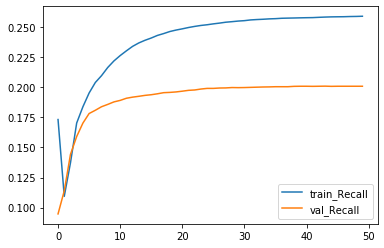

In [29]:
# Plot the Recall metric at each itteration
plt.plot(result.history['Recall'], label='train_Recall');
plt.plot(result.history['val_Recall'], label='val_Recall');
plt.legend();

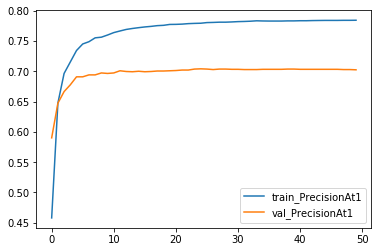

In [30]:
# Plot the PrecisionAt1 metric at each itteration
plt.plot(result.history['PrecisionAt1'], label='train_PrecisionAt1');
plt.plot(result.history['val_PrecisionAt1'], label='val_PrecisionAt1');
plt.legend();

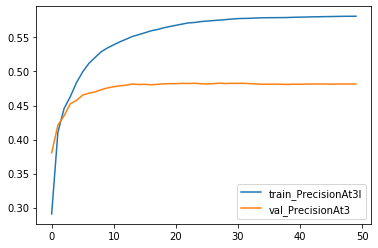

In [31]:
# Plot the PrecisionAt3 metric at each itteration
plt.plot(result.history['PrecisionAt3'], label='train_PrecisionAt3l');
plt.plot(result.history['val_PrecisionAt3'], label='val_PrecisionAt3');
plt.legend();

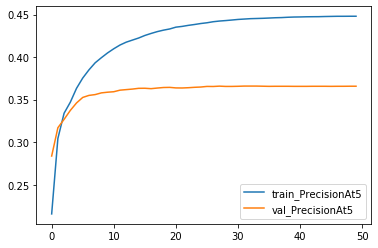

In [32]:
# Plot the PrecisionAt5 metric at each itteration
plt.plot(result.history['PrecisionAt5'], label='train_PrecisionAt5');
plt.plot(result.history['val_PrecisionAt5'], label='val_PrecisionAt5');
plt.legend();

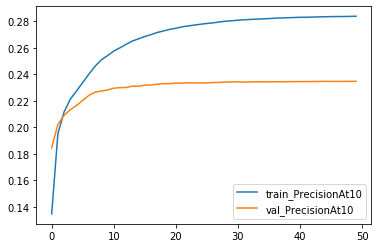

In [33]:
# Plot the PrecisionAt10 metric at each itteration
plt.plot(result.history['PrecisionAt10'], label='train_PrecisionAt10');
plt.plot(result.history['val_PrecisionAt10'], label='val_PrecisionAt10');
plt.legend();